In [1]:
import numpy as np
from threading import Thread
import torch
from img2vec import img2vec
from sklearn.metrics import confusion_matrix

In [2]:
def read_labels(path, labels):
    # 以只读模式打开txt文件
    with open(path, 'r') as f:
        # 遍历文件中的每一行
        for line in f:
            # 去掉行尾的换行符
            line = line.strip()
            # 把行中的数字转换为整数类型，并添加到列表中
            labels.append(int(line))

In [3]:
class KNN:
    def __init__(self, k, train_size):
        self.k = k
        self.train_size = train_size
        self.train_vectors = np.empty(shape=[self.train_size, 784])
        self.test_vector = np.empty(shape=[1, 784])
        self.train_labels = []
        self.test_labels = []
        # train_label_path = r"D:\大学文件\大三下\人工智能导论\Mnist\labels_train.txt"
        train_label_path = r"labels/labels_train.txt"
        test_label_path = r"labels/labels_test.txt"
        read_labels(train_label_path, self.train_labels)
        read_labels(test_label_path, self.test_labels)
        self.train_vectors = torch.from_numpy(np.loadtxt('train_vectors.txt')).cuda()

    def classify(self, path):
        self.test_vector = torch.from_numpy(img2vec(path)).cuda()
        # 矩阵运算，计算测试数据与每个样本数据对应数据项的差值
        diff_mat = torch.tile(self.test_vector, (self.train_size, 1)) - self.train_vectors
        # 差值求绝对值
        diff_mat = torch.abs(diff_mat)
        # # 上一步骤结果平方和
        # square_mat = torch.pow(diff_mat, 2)
        # square_distances = torch.sum(square_mat, dim=1)
        #
        # # 取平方根，得到距离向量
        # distances = torch.sqrt(square_distances)

        # 上一步骤结果立方和
        cube_mat = torch.pow(diff_mat, 3)
        cube_distances = torch.sum(cube_mat, dim=1)

        # 取立方根，得到距离向量
        distances = torch.pow(cube_distances, 1 / 3)

        # 或者可以直接用这一行代码来计算 L3 距离
        # distances = torch.norm(diff_mat, p=3, dim=1)

        # 按照距离从低到高排序
        sorted_distances = torch.argsort(distances)

        labels = [0] * 10
        for i in range(0, self.k):
            # 获取第i近的图片对应的标签
            label = self.train_labels[sorted_distances[i]]
            # 根据距离的倒数计算权重，距离越小权重越大
            weight = 1 / distances[sorted_distances[i]]
            # 对应类别增加权重
            labels[label] += weight
        # 找出权重最大的类别对应的索引值，代表分类结果
        max_value = max(labels)
        max_index = labels.index(max_value)
        return max_index

    # 多线程执行中每一个线程执行的函数
    def target(self, test_begin, test_end, counts, predictions, true_labels):
        count = 0  # 局部变量，存储每一个线程的成功识别次数
        file_root = r"D:\大学文件\大三下\人工智能导论\Mnist\img_test"
        for i in range(test_begin, test_end):
            file_path = file_root + '\\' + '%s.png' % i
            value = self.classify(file_path)
            if value == self.test_labels[i]:
                count += 1
            predictions[i] = value
            true_labels[i] = self.test_labels[i]
        counts[test_begin] = count  # 把count变量存储到字典中

    def evaluate(self, test_size, jobs):
        # 用给定的测试大小，线程数来创建和管理线程，并计算准确率和混淆矩阵
        threads = []  # 一个列表来存储线程对象
        counts = {}  # 一个字典来存储每个线程的count变量
        predictions = {}  # 一个字典来存储每个样本的预测结果
        true_labels = {}  # 一个字典来存储每个样本的真实标签
        step = test_size // jobs  # 计算每个子范围的大小
        for i in range(0, test_size, step):  # 创建5个线程
            if i + step > test_size:
                end = test_size
            else:
                end = i + step
            # 创建一个线程对象，并把目标函数，开始位置、结束位置和counts, predictions, true_labels作为实参传递给它
            t = Thread(target=self.target, args=(i, end, counts, predictions, true_labels))
            threads.append(t)  # 把线程对象添加到列表中
            t.start()  # 启动线程

        for t in threads:  # 等待所有的线程结束
            t.join()

        total_count = sum(counts.values())  # 计算所有线程的count变量之和
        accuracy = total_count / test_size  # 计算准确率

        # 生成混淆矩阵
        y_pred = np.array([predictions[i] for i in range(test_size)])
        y_true = np.array([true_labels[i] for i in range(test_size)])
        cm = confusion_matrix(y_true, y_pred)

        return accuracy, cm


In [4]:
k = 4
a = KNN(k, 60000)
test_size = 10000
acc, cm = a.evaluate(test_size, 3)
np.savetxt('confusion_matrix.txt', cm, fmt='%d')
print(f"距离:L3,k:{k},测试数量:{test_size},准确率:{acc}")

距离:L3,k:4,测试数量:10000,准确率:0.9743


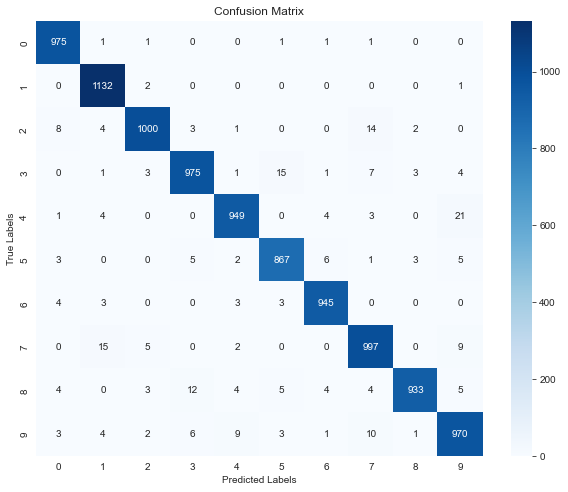

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# 绘制混淆矩阵热力图
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()




In [6]:
# k遍历3-10,评估不同k对应的KNN模型的准确率
for k in range(3, 11):
    a = KNN(k, 60000)
    test_size = 10000
    acc, cm = a.evaluate(test_size, 3)
    print(f"距离:L3,k:{k},测试数量:{test_size},准确率:{acc}")

距离:L3,k:3,测试数量:10000,准确率:0.9728
距离:L3,k:4,测试数量:10000,准确率:0.9743
距离:L3,k:5,测试数量:10000,准确率:0.9735
距离:L3,k:6,测试数量:10000,准确率:0.9737
距离:L3,k:7,测试数量:10000,准确率:0.9722
距离:L3,k:8,测试数量:10000,准确率:0.9724
距离:L3,k:9,测试数量:10000,准确率:0.9708
距离:L3,k:10,测试数量:10000,准确率:0.9714


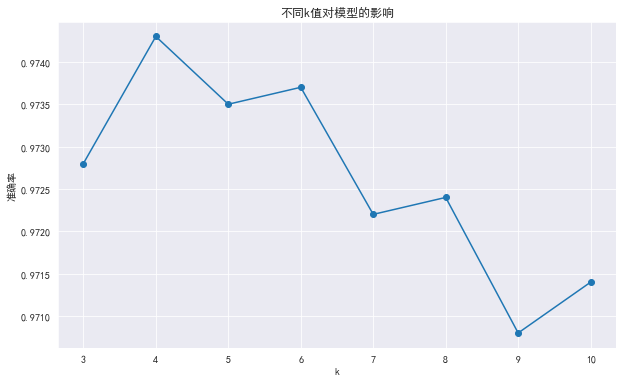

In [9]:
# 读取文件并解析数据
k = []  # k值
accuracy = []  # 准确率

plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文显示字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

with open('test_result.txt', 'r', encoding='utf-8') as file:
    for line in file:
        line = line.strip()
        if line:
            # 解析每一行数据
            line_parts = line.split(',')
            k_value = int(line_parts[1].split(':')[1])
            accuracy_value = float(line_parts[3].split(':')[1])

            # 添加数据到相应的列表
            k.append(k_value)
            accuracy.append(accuracy_value)

# 创建图形并绘制折线
plt.figure(figsize=(10, 6))
plt.plot(k, accuracy, marker='o')

# 设置图形标题和轴标签
plt.title('不同k值对模型的影响')
plt.xlabel('k')
plt.ylabel('准确率')

# 显示图形
plt.show()